In [1]:
a = (5,6,7)

In [3]:
def test_fn(a,b,c):
    print (a,b,c)

In [4]:
test_fn(*a)

5 6 7


In [74]:
import glob
from itertools import product

In [78]:
for aa, gg in [m for m in product([3,4,5],['r','d','g'])]:
    print (aa,gg)

3 r
3 d
3 g
4 r
4 d
4 g
5 r
5 d
5 g


In [2]:
import xarray as xr

In [17]:
import numpy as  np

In [23]:
import dask.array

In [25]:
ds = xr.open_dataset('2010-jan.grib', chunks = {'longitude':10,'latitude':10,'steps':61,'time':1461}, engine='cfgrib')

Ignoring index file '2010-jan.grib.923a8.idx' older than GRIB file


In [6]:
import numpy as np

In [7]:
np.random.rand()

0.7688380611818286

In [5]:
np.round(np.random.rand())

NameError: name 'np' is not defined

In [15]:
def baseround(x, base):
    return base * np.round(x/base)
def basefloor(x, base):
    return base * np.floor(x/base)
def baseceil(x, base):
    return base * np.ceil(x/base)

In [19]:
1.3/6

0.21666666666666667

In [63]:
test_geom = """
{
        "type": "Polygon",
        "coordinates": [
          [
            [
              78.22265625,
              19.81839009384496
            ],
            [
              76.08032226562499,
              19.828725387681168
            ],
            [
              73.839111328125,
              19.518375478601566
            ],
            [
              74.64111328125,
              18.916679786648565
            ],
            [
              76.102294921875,
              18.95824648598139
            ],
            [
              76.146240234375,
              17.434510551522894
            ],
            [
              76.409912109375,
              17.329664329425057
            ],
            [
              76.61865234374999,
              19.01019029439606
            ],
            [
              77.16796875,
              19.072501451715087
            ],
            [
              76.937255859375,
              19.559790136497412
            ],
            [
              77.882080078125,
              19.497664168139053
            ],
            [
              78.2666015625,
              19.580493479202527
            ],
            [
              78.22265625,
              19.81839009384496
            ]
          ]
        ]
      }
"""

In [36]:
import json

In [38]:
from shapely import geometry

In [64]:
test_geom = geometry.shape(json.loads(test_geom))

In [65]:
test_geom.bounds

(73.839111328125, 17.329664329425057, 78.2666015625, 19.828725387681168)

In [29]:
import rasterio as rio

In [30]:
from rasterio.features import rasterize

In [32]:
from skimage.measure import block_reduce

In [104]:
def get_shape_coverage(geom,explode_factor,wgs_resolution):
    """ takes a shapely geometry and returns a numpy array mask of the bounds extents.
    
    Parameters
    ----------
    
    geom: shapely.geometry
        The shapely geometry in wgs84 coordinates to mask
    explode_factor: int
        A resampling factor for the raster, higher gives more precise coverage in non-full and non-empty pixels
    wgs_resolution: float
        The resolution to rasterise in, e.g. for downstream masking tasks.
    """
    
    ### build a big array to burn in
    # get dimensions first
    L = basefloor(geom.bounds[0],wgs_resolution)
    R = baseceil(geom.bounds[2],wgs_resolution)
    B = basefloor(geom.bounds[1], wgs_resolution)
    T = baseceil(geom.bounds[3], wgs_resolution)
    
    big_arr = np.zeros((int((T-B)/wgs_resolution)*explode_factor, int((R-L)/wgs_resolution)*explode_factor), dtype=np.uint8)
    
    # build an affine transform for the big array
    affine = rio.transform.from_bounds(L, B, R, T, big_arr.shape[1], big_arr.shape[0])
    
    if geom.type=='Polygon':
        geom_list = [geom]
    elif geom.type=='MultiPolygon':
        geom_list = list(geom)
    
    # burn-in the big array
    rasterize(geom_list, 
              fill=0, 
              default_value = 1,
              out=big_arr, 
              transform=affine, 
    )
    
    # block-reduce and normalise
    ann = block_reduce(big_arr, (explode_factor, explode_factor), np.sum) / explode_factor / explode_factor
    new_affine = rio.transform.from_bounds(L,B,R,T, ann.shape[1], ann.shape[0])
    return ann, new_affine

In [105]:
ann, affine = get_shape_coverage(test_geom, 10, 0.5)

In [94]:
test_geom.bounds

(73.839111328125, 17.329664329425057, 78.2666015625, 19.828725387681168)

In [101]:
ann.shape

(6, 10)

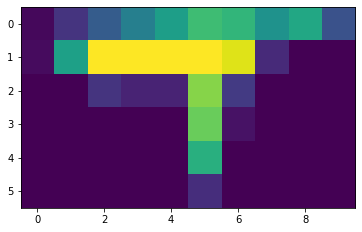

In [106]:
import matplotlib.pyplot as plt
plt.imshow(ann)

In [107]:
ann

array([[0.02, 0.15, 0.29, 0.43, 0.56, 0.69, 0.66, 0.51, 0.6 , 0.25],
       [0.03, 0.57, 1.  , 1.  , 1.  , 1.  , 0.95, 0.12, 0.  , 0.  ],
       [0.  , 0.  , 0.15, 0.1 , 0.1 , 0.82, 0.17, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.77, 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.63, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.  , 0.  , 0.  ]])

In [108]:
affine

Affine(0.5, 0.0, 73.5,
       0.0, -0.5, 20.0)

<xarray.Dataset>
Dimensions:            (latitude: 361, longitude: 720, step: 61, time: 31)
Coordinates:
    number             int64 ...
  * time               (time) datetime64[ns] 2010-01-01 ... 2010-01-31
  * step               (step) timedelta64[ns] 0 days 00:00:00 ... 15 days 00:...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 90.0 89.5 89.0 ... -89.0 -89.5 -90.0
  * longitude          (longitude) float64 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
    valid_time         (time, step) datetime64[ns] dask.array<chunksize=(31, 61), meta=np.ndarray>
    surface            float64 ...
Data variables:
    t2m                (time, step, latitude, longitude) float32 dask.array<chunksize=(31, 61, 10, 10), meta=np.ndarray>
    tp                 (time, step, latitude, longitude) float32 dask.array<chunksize=(31, 61, 10, 10), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-07-18T22:22 GRIB to CDM+CF via cfgrib-0.9.9...

In [36]:
# get slices to write
slices = dask.array.core.slices_from_chunks(dask.array.empty_like(ds.to_array()).chunks) # null, time, lat, lon

In [37]:
slices[0]

(slice(0, 1, None),
 slice(0, 31, None),
 slice(0, 61, None),
 slice(0, 10, None),
 slice(0, 10, None))

In [31]:
len(slices)

5328

In [38]:
slices = [s for s in slices if s[3].stop!=361]

In [39]:
len(slices)

5184

In [40]:
select_slice = slices[1000]

In [41]:
ds['tp'].shape

(31, 61, 361, 720)

In [42]:
select_slice

(slice(0, 1, None),
 slice(0, 31, None),
 slice(0, 61, None),
 slice(130, 140, None),
 slice(640, 650, None))

In [44]:
data = ds['tp'][select_slice[1], select_slice[2], select_slice[3], select_slice[4]].values

In [57]:
np.transpose(data, [3,2,0,1]).shape

(10, 10, 31, 61)

In [53]:
store = gcsfs.GCSMap(root='oxeo-forecasts/ecmwf-tigge-15day')
z = zarr.open(store)

In [62]:
offset_slice = select_slice[1]
step_slice = select_slice[2]
lat_slice = select_slice[3]
lon_slice = select_slice[4]

In [63]:
z['tp'][lon_slice, lat_slice, offset_slice, step_slice] = np.transpose(data, [3,2,0,1])

In [65]:
import os

In [69]:
year, month = os.path.splitext(os.path.split('home/2010_01.grib')[1])[0].split('_')

In [71]:
year,month

('2010', '01')

In [73]:
f'{int(month):02d}'

'01'

In [58]:
from datetime import datetime as dt

In [61]:
(dt(year=2018, month=5, day=1) - dt(2016,5,9)).days

722

In [27]:
ds['tp'].shape # time, step, lat, lon

(31, 61, 361, 720)

In [22]:
ds['tp'].shape

(31, 61, 361, 720)

In [7]:
import pandas as pd

In [ ]:

    
# get slices to write
slices = dask.array.core.slices_from_chunks(dask.array.empty_like(ds.to_array()).chunks) # null, time, lat, lon